# CSE-CIC-IDS 2017

In [1]:
model_id = "rnn2-classweights"

In [2]:
import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

import glob, time, os

import keras

Using TensorFlow backend.
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [4]:
NOTEBOOK_PATH = "C:/Users/Xetrov/Desktop/SciFair20/Code/"

In [5]:
x_scaled = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_scaled_powertransform.csv")
y_df_enc = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_grouped_1henc.csv")

In [6]:
x_scaled_npy = np.expand_dims(x_scaled.to_numpy(), axis=-1)

In [7]:
x_scaled_npy.shape

(2830743, 68, 1)

# Split data into train and test

In [8]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_valtest, y_train, y_valtest = train_test_split(x_scaled_npy, y_df_enc, test_size = 0.4, random_state = 42)

In [19]:
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, random_state = 42)

In [20]:
del x_valtest 
del y_valtest

In [21]:
y_train.sum(axis=0)

BENIGN          1364100
Botnet             1185
Brute Force        8273
DoS/DDoS         228292
Infiltration         24
PortScan          95267
Web Attack         1304
dtype: int64

In [22]:
y_val.sum(axis=0)

BENIGN          454207
Botnet             397
Brute Force       2810
DoS/DDoS         76510
Infiltration         7
PortScan         31787
Web Attack         431
dtype: int64

In [23]:
y_test.sum(axis=0)

BENIGN          454790
Botnet             384
Brute Force       2752
DoS/DDoS         75897
Infiltration         5
PortScan         31876
Web Attack         445
dtype: int64

# Train model

In [24]:
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, InputLayer
from keras.optimizers import SGD, Adam

In [25]:
x_train.shape[1:]

(68, 1)

In [26]:
def addDenseBlock(model, units, **params):
    model.add(Dense(units=units, activation=params['hidden_activation'], input_dim=x_train.shape[1]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))

def addLSTMBlock(model, units, return_sequences=False, **params):
    model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=x_train.shape[1:]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))
        
def createModel(**in_params):
    """
    Supported parameters:
    batch_normalization - True or False
    dropout_rate - 0 to 1
    num_units - integer
    learning_rate - float
    activation_function - string
    """
    
    model = Sequential()

    # Set default values
    params = {
        'batch_normalization': False,
        'dropout_rate': 0,
        'num_layers': 6,
        'num_units': 128,
        'learning_rate': 0.001,
        'hidden_activation': 'relu',
        'final_activation': 'softmax'
    }
    
    # Replace defaults with specified parameters
    for param in in_params:
        params[param] = in_params[param]    
    
    # InputLayer causes serialization issues
#     model.add( InputLayer(input_shape = (x_train.shape[1],) ) )
    
#     for i in range(params['num_layers']):
#         addDenseBlock(model, params['num_units'], **params)

    addLSTMBlock(model, 64, **params)

    model.add(Dense(units=y_train.shape[1], activation=params['final_activation']))

    # optim = SGD(lr=0.001, nesterov=True)
    optim = Adam(lr=params['learning_rate'])

    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
#     print(params)
    
    return model

Ensure a GPU is available

In [27]:
import keras.backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Callbacks

In [28]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

def timestamp():
    return time.strftime("%m-%d-%Y, %I%M%p")

csv_callback = CSVLogger(NOTEBOOK_PATH + 'Loss Logs/%s (%s)' % (model_id, timestamp()), append=True)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5)

### Model Saving

In [29]:
savedir = NOTEBOOK_PATH + "Models/%s/" % model_id
if not os.path.exists(savedir):
    os.makedirs(savedir)
    print("Created " + savedir)
else:
    print("Using " + savedir)

Created C:/Users/Xetrov/Desktop/SciFair20/Code/Models/rnn2-classweights/


### Class weights


In [30]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# https://stackoverflow.com/a/50695814
y_integers = np.argmax(y_train.to_numpy(), axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

d_class_weights

{0: 0.17787185690198665,
 1: 204.75527426160338,
 2: 29.328538619605947,
 3: 1.0628274315350517,
 4: 10109.791666666666,
 5: 2.5468945175139344,
 6: 186.06978527607362}

### Training

In [31]:
import itertools

trainEpochs = 35

parameters = {'batch_size': 250, 'batch_normalization':True,'dropout_rate':0}

In [32]:
%%time
print(model_id)
model = createModel(**parameters)
model.summary()
model_checkpoint = ModelCheckpoint(NOTEBOOK_PATH + "Models/%s/rnn({epoch}).h5" % (model_id), monitor='val_loss')
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=parameters['batch_size'], epochs=trainEpochs, verbose=2, callbacks=[csv_callback, model_checkpoint], class_weight=d_class_weights)

rnn2-classweights
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 17,607
Trainable params: 17,479
Non-trainable params: 128
_________________________________________________________________
Train on 1698445 samples, validate on 566149 samples
Epoch 1/35
 - 686s - loss: 1.3122 - acc: 0.2919 - val_loss: 2.2489 - val_acc: 0.0737
Epoch 2/35
 - 685s - loss: 1.3115 - acc: 0.3077 - val_loss: 1.3509 - val_acc: 0.4514
Epoch 3/35
 - 686s - loss: 1.3390 - acc: 0.3769 - val_loss: 1.6381 - val_acc: 0.3805
Epoch 4/35
 - 685s - loss: 0.9031 - acc: 0.5185 - val_loss: 1.2583 - val_a

# Graph the losses

In [33]:
def most_recent_file(pattern):
    return max(glob.iglob(pattern, recursive=True), key=os.path.getctime)

logpath = most_recent_file(NOTEBOOK_PATH + "Loss Logs/%s**" % model_id)
log_df = pd.read_csv(logpath)
log_df['epoch'] += 1

print(logpath)

C:/Users/Xetrov/Desktop/SciFair20/Code/Loss Logs\rnn2-classweights (10-13-2019, 1052PM)


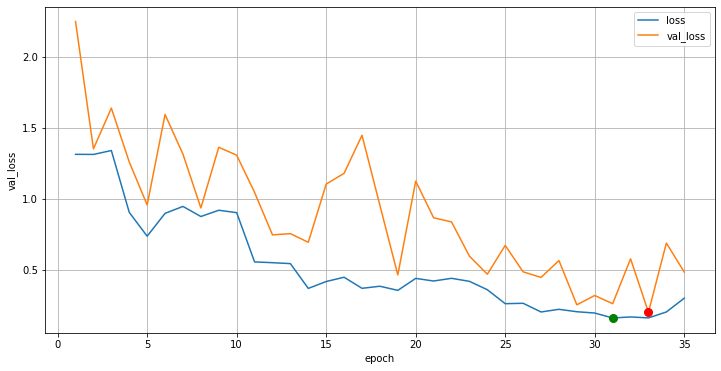

In [34]:
plot_df = log_df[:]

metric = 'loss'

plt.figure(figsize=(12,6))
sns.lineplot(x='epoch', y=metric, data=plot_df, label=metric)
sns.lineplot(x='epoch', y='val_'+metric, data=plot_df, label='val_'+metric)
plt.legend()

minEpoch = plot_df.loc[plot_df.idxmin()[metric]]
plt.plot((minEpoch['epoch']), (minEpoch[metric]), 'go', markersize=8)
minEpoch = plot_df.loc[plot_df.idxmin()['val_'+metric]]
plt.plot((minEpoch['epoch']), (minEpoch['val_'+metric]), 'ro', markersize=8)

plt.xticks(list(range(0, plot_df['epoch'].max()+1, 5)))
# plt.yticks(list(np.arange(0.0,0.4,0.05)))

plt.grid(True)

# Test Data

In [35]:
from sklearn.metrics import f1_score

In [36]:
pred = model.predict(x_test, batch_size=256).argmax(axis=1)
pred_f1 = np.zeros((len(x_test), y_test.shape[1]))
for j in range(len(pred)):
    pred_f1[j,pred[j]] = 1
f1_micro = f1_score(y_test, pred_f1.astype('uint8'), average='micro')
f1_macro = f1_score(y_test, pred_f1.astype('uint8'), average='macro')
print("Micro:", f1_micro)
print("Macro:", f1_macro)

Micro: 0.84398806674568
Macro: 0.5400774663961957


In [37]:
pred_index = pred
y_index = list(np.argmax(y_test.to_numpy(), axis=1))

atktypes = sorted(y_test.columns)
pred_series = pd.Series(pred_index, name="Pred").replace(dict(enumerate(atktypes)))
y_series = pd.Series(y_index, name="Actual").replace(dict(enumerate(atktypes)))

matrix = pd.crosstab(pred_series, y_series, margins=True)
print("Done!")
matrix.to_csv(NOTEBOOK_PATH + "Confusion Matrices/%s.csv" % model_id)
matrix

Done!


Actual,BENIGN,Botnet,Brute Force,DoS/DDoS,Infiltration,PortScan,Web Attack,All
Pred,,,,,,,,
BENIGN,367270,0,0,165,2,124,1,367562
Botnet,16248,366,1,2,0,62,0,16679
Brute Force,1119,0,2751,0,0,46,0,3916
DoS/DDoS,4236,0,0,75426,0,22,1,79685
Infiltration,54627,10,0,3,3,38,0,54681
PortScan,6432,8,0,15,0,31564,0,38019
Web Attack,4858,0,0,286,0,20,443,5607
All,454790,384,2752,75897,5,31876,445,566149


# Log results

In [72]:
model_log = open(NOTEBOOK_PATH + "model_log.txt", "a")

model_log.write("\n" + model_filename)
model_log.write("\n\tF1 Micro: " + str(f1_micro))
model_log.write("\n\tF1 Macro: " + str(f1_macro))

model_log.close()